## IMPUTATION

Those are the three database....

In [1]:
import missingpy
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
folder="D:\\smarcitiesdata\\DatiAirQuality\\Aggregated_Data"
list_of_database=os.listdir(folder)

In [3]:
list_of_database

['passages1.csv',
 'passages2.csv',
 'pollution1.csv',
 'pollution2.csv',
 'weather.csv']

In [4]:
filepath_passages1=folder+"\\"+list_of_database[0]
filepath_passages2=folder+"\\"+list_of_database[1]
filepath_pollution1=folder+"\\"+list_of_database[2]
filepath_pollution2=folder+"\\"+list_of_database[3]
filepath_weather=folder+"\\"+list_of_database[4]

first we merge again the pollution db

In [5]:
pollution1=pd.read_csv(filepath_pollution1)
pollution2=pd.read_csv(filepath_pollution2)
pollution=pd.merge(pollution1,pollution2,how='outer',on='tempo')

load the passages

In [7]:
passages=pd.read_csv(filepath_passages2)

load the weather

In [8]:
weather=pd.read_csv(filepath_weather)

function to check for the missing

In [9]:
def heatmap_missing(db):
    cmap_colour=['grey','azure']
    if db.index.name=='tempo':
            db['temporal']=db.index
    else:
            db['temporal']=pd.to_datetime(db['tempo'])
    dt = datetime.datetime.fromtimestamp(db['temporal'].min().timestamp())
    end =datetime.datetime.fromtimestamp (db['temporal'].max().timestamp())
    step = datetime.timedelta(hours=1)
    result=[]
    while dt < end:
        result.append(dt)
        dt += step
    result_timestamps=pd.to_datetime(result)
    fig,axs=plt.subplots(ncols=1,figsize=(10,10))
    left_db=pd.DataFrame(result_timestamps,columns=['temporal'])
    left_db=pd.merge(left_db,db,on='temporal')
    left_db.set_index(left_db['temporal'].dt.strftime('%m-%d'),inplace=True)
    left_db.sort_index(ascending=False,inplace=True)
    ax=sns.heatmap(left_db.iloc[:,1:].isnull(), cbar=True,cmap=cmap_colour);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([0.25, 0.75])
    colorbar.set_ticklabels(['AVAILABLE', 'MISSING'])
    #ax.set_title('HOURLY missing values by variables');
    plt.suptitle('missing values by variables',fontsize=14);
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    # this is to change the colours
    #ax.tick_params(axis='x', colors='red')
    db.drop('temporal',axis=1,inplace=True)
    del left_db

do the big merge and visualize it

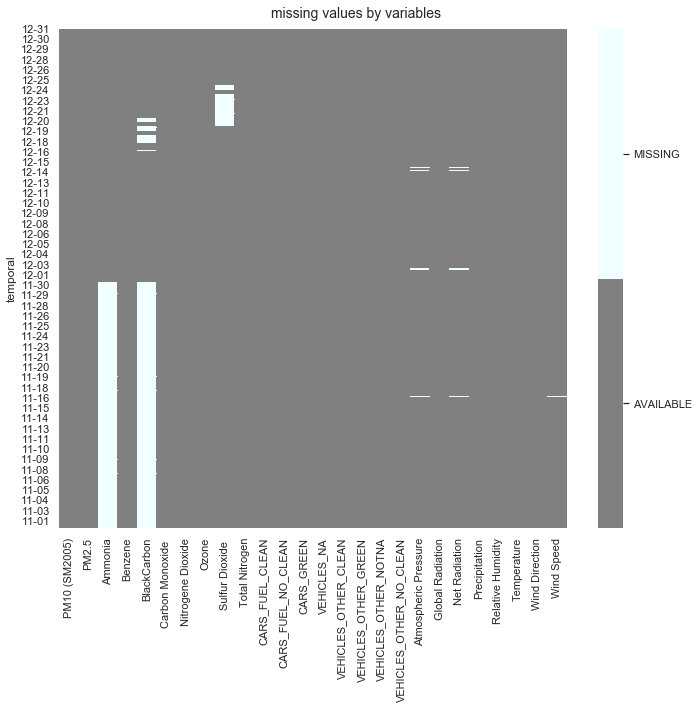

In [10]:
db_to_merge=[pollution,passages,weather]
for db in db_to_merge:
    db['tempo']=pd.to_datetime(db['tempo'])

## create list of variables
pollution_variables=list(pollution.columns)
pollution_variables.remove('tempo')
weather_variables=list(weather.columns)
weather_variables.remove('tempo')
passages_variables=list(passages.columns)
passages_variables.remove('tempo')


db_final=pd.merge(db_to_merge[0],db_to_merge[1],on='tempo',how='outer')
db_final=pd.merge(db_final,db_to_merge[2],on='tempo',how='outer')
db_final.set_index('tempo',inplace=True)
### fill gaps due to resampling method
db_final['PM10 (SM2005)'].fillna(40,inplace=True)
db_final['PM2.5'].fillna(38,inplace=True)
###

heatmap_missing(db_final)


## IMPUTATION

In [11]:
imputer = missingpy.MissForest()
db_imputed = imputer.fit_transform(db_final)
db_imputed=pd.DataFrame(db_imputed,columns=db_final.columns,index=db_final.index)

Iteration: 0
Iteration: 1
Iteration: 2


## Create new variables

## Exponential smoothing

In [12]:
from sklearn import preprocessing
import statsmodels.api as sm

In [13]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

Smoothed Variables for weather

In [14]:
weather_smoothed=pd.DataFrame()
weather_variables_smoothed=[]

for var_w in weather_variables:
    smoothed_var=SimpleExpSmoothing(db_imputed[var_w]).fit(0.01)
    new_smoothed_var=var_w+'_SMOOTH'
    weather_variables_smoothed.append(new_smoothed_var)
    weather_smoothed[new_smoothed_var]=smoothed_var.fittedvalues
    # other_var.fittedvalues.plot()
    #db_imputed[weather_variables[2]].plot()
    
weather_smoothed

C:\Users\gabri\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\gabri\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\gabri\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\gabri\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\gabri\AppData\Local\Continuum\anaconda3\lib\site-packages\stat

,Atmospheric Pressure_SMOOTH,Global Radiation_SMOOTH,Net Radiation_SMOOTH,Precipitation_SMOOTH,Relative Humidity_SMOOTH,Temperature_SMOOTH,Wind Direction_SMOOTH,Wind Speed_SMOOTH
tempo,,,,,,,,
2013-11-01 00:00:00,996.325920,55.256818,14.294980,0.093530,81.286275,12.885372,158.957062,1.443345
2013-11-01 01:00:00,996.400711,54.704249,13.825530,0.092602,81.378892,12.856276,158.368825,1.439027
2013-11-01 02:00:00,996.509703,54.157207,13.147274,0.091676,81.463104,12.843713,159.851803,1.429636
2013-11-01 03:00:00,996.613606,53.615635,12.515802,0.090759,81.544473,12.827276,160.226619,1.423340
2013-11-01 04:00:00,996.713470,53.079478,11.860644,0.089851,81.637028,12.807837,160.801019,1.414107
2013-11-01 05:00:00,996.809336,52.548684,11.182037,0.088953,81.736658,12.785092,161.503009,1.406965
2013-11-01 06:00:00,996.902242,52.023197,10.570217,0.088063,81.853291,12.760074,160.734646,1.397896
2013-11-01 07:00:00,996.994220,51.502965,10.054515,0.087183,81.970758,12.731640,161.487299,1.390917
2013-11-01 08:00:00,997.085278,50.987935,9.603970,0.086311,82.095050,12.702324,160.352426,1.386008


Smoothed Variables for Passages

In [15]:
passages_smoothed=pd.DataFrame()
passages_variables_smoothed=[]
for var_w in passages_variables:
    smoothed_var=SimpleExpSmoothing(db_imputed[var_w]).fit(0.01)
    new_smoothed_var=var_w+'_SMOOTH'
    passages_variables_smoothed.append(new_smoothed_var)
    passages_smoothed[new_smoothed_var]=smoothed_var.fittedvalues
    # other_var.fittedvalues.plot()
    #db_imputed[passages_variables[2]].plot()
    
passages_smoothed

C:\Users\gabri\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\gabri\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\gabri\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\gabri\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\gabri\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarni

,CARS_FUEL_CLEAN_SMOOTH,CARS_FUEL_NO_CLEAN_SMOOTH,CARS_GREEN_SMOOTH,VEHICLES_NA_SMOOTH,VEHICLES_OTHER_CLEAN_SMOOTH,VEHICLES_OTHER_GREEN_SMOOTH,VEHICLES_OTHER_NOTNA_SMOOTH,VEHICLES_OTHER_NO_CLEAN_SMOOTH
tempo,,,,,,,,
2013-11-01 00:00:00,1021.713478,1502.948640,410.347099,643.367110,295.180103,60.516245,7.135700,12.027223
2013-11-01 01:00:00,1016.606344,1496.079153,408.253628,638.733438,292.688302,59.951083,7.064343,11.936951
2013-11-01 02:00:00,1009.860280,1486.508362,405.611092,633.496104,290.141419,59.361572,6.993700,11.827581
2013-11-01 03:00:00,1001.941677,1475.143278,402.574981,628.011143,287.540005,58.787956,6.923763,11.709305
2013-11-01 04:00:00,993.462261,1463.161845,399.279231,622.401032,284.894605,58.250077,6.854525,11.602212
2013-11-01 05:00:00,984.727638,1451.560227,395.666439,616.687021,282.395659,57.707576,6.785980,11.516190
2013-11-01 06:00:00,976.060362,1439.574625,392.259775,611.180151,280.071702,57.230500,6.718120,11.431028
2013-11-01 07:00:00,967.719758,1427.588878,389.057177,605.878350,278.000985,56.778195,6.650939,11.336718
2013-11-01 08:00:00,959.372560,1415.952990,385.816605,600.919566,276.080975,56.270413,6.584430,11.253351


Now we eventually add those variables to our dataset

In [16]:
final_dataframe=pd.concat([db_imputed,passages_smoothed,weather_smoothed],axis=1,join='inner')

### now we eventually have the final dataframe...

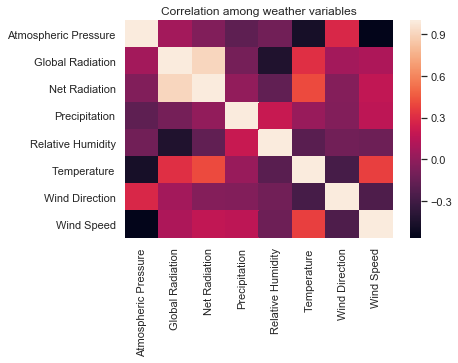

In [17]:
corr=final_dataframe.loc[:,weather_variables].corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns);
plt.title('Correlation among weather variables');

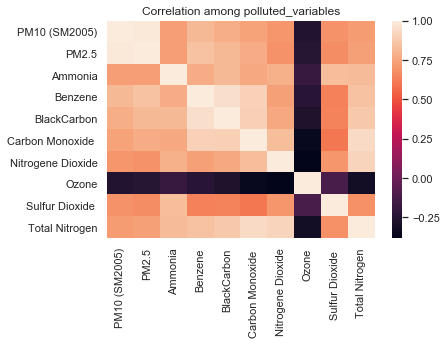

In [18]:
corr=final_dataframe.loc[:,pollution_variables].corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns);
plt.title('Correlation among polluted_variables');

## This is the big correlation matrix

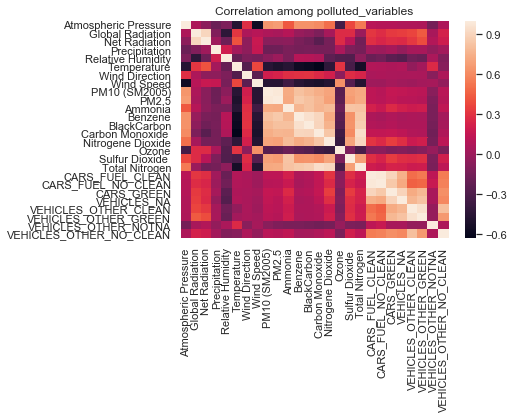

In [19]:
corr=final_dataframe.loc[:,weather_variables+pollution_variables+passages_variables].corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns);
plt.title('Correlation among polluted_variables');

## now  let's write down the databse

In [26]:
path="D:\\smarcitiesdata\\final_dataframe.csv"
final_dataframe.to_csv(path)

In [27]:
path_weather="D:\\smarcitiesdata\\weather_variables.csv"
pd.DataFrame(weather_variables,columns=['weather_variables']).to_csv(path_weather)

In [28]:
path_pollution="D:\\smarcitiesdata\\pollution_variables.csv"
pd.DataFrame(pollution_variables,columns=['pollution_variables']).to_csv(path_pollution)

In [29]:
path_passages="D:\\smarcitiesdata\\passages_variables.csv"
pd.DataFrame(passages_variables,columns=['passages_variables']).to_csv(path_passages)

In [30]:
path_passages="D:\\smarcitiesdata\\passages_variables_smoothed.csv"
pd.DataFrame(passages_variables_smoothed,columns=['passages_variables_smoothed']).to_csv(path_passages)

In [31]:
path_weather="D:\\smarcitiesdata\\weather_variables_smoothed.csv"
pd.DataFrame(weather_variables_smoothed,columns=['weather_variables_smoothed']).to_csv(path_weather)